2024-02-27 15:54:03.986730: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_6 (InputLayer)           [(None, 224, 224, 1  0           []                               

                                )]                                                                

                                                                                                  

 sequential_1 (Sequential)      (None, 4096)         21557952    ['input_6[0][0]']                

                                                                                                  

 densenet201 (Functional)       (None, 1920)         18315712    ['input_6[0][0]']                

                                                                                                  

 ResNet50 (Functional)          (None, 2048)         23581440    ['input_6[0][0]'

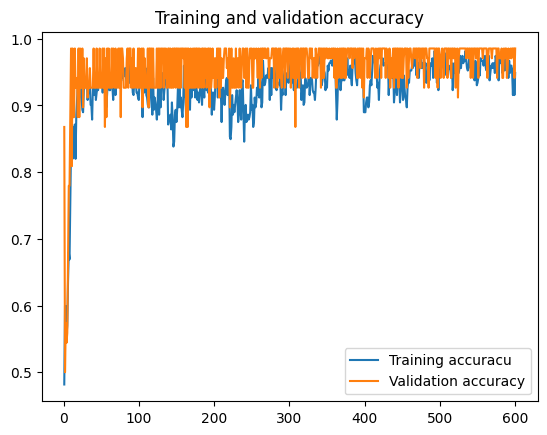

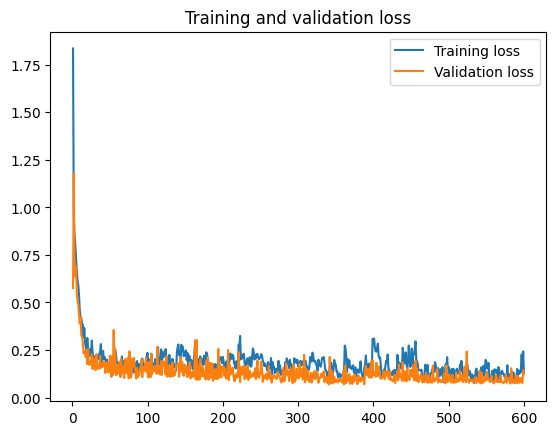

Confusion Matrix:

[[27  2]

 [ 1 31]]


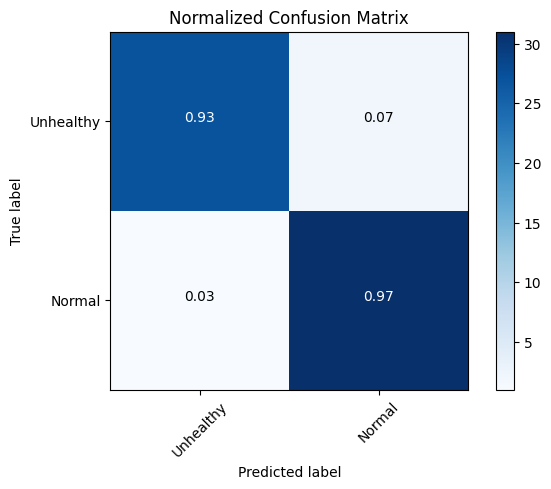

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import cv2
import os
import time
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, auc
import matplotlib.pyplot as plt
import itertools
import json
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy import interpolate
from itertools import cycle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

X_shape = 224
model = load_model('/home/syasun/hybrid/ensemble_model_1024_features_vector_v5.h5')

model.summary()

def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(224, 224), color_mode="grayscale")
        img_array = img_to_array(img)
        
        
        label = 1 if "_1." in filename else 0

        images.append(img_array)
        labels.append(label)
    return images, labels

folder_A = '/home/syasun/CXR_png'
images_train_A, labels_train_A = load_images_from_folder(folder_A)

####################################################################################
random_state = int(time.time())

X_train, X_test, y_train, y_test = train_test_split(np.array(images_train_A), np.array(labels_train_A), test_size=0.15, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

ensemble_features = model.predict(X_train)
ensemble_features_val = model.predict(X_val)

X_train_reshaped = ensemble_features.reshape((ensemble_features.shape[0], -1))
X_val_reshaped = ensemble_features_val.reshape((ensemble_features_val.shape[0], -1))

pretrained_output_size = model.output_shape

classifier_input = Input(shape=(pretrained_output_size))
x = Dense(128, activation='relu')(classifier_input)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)
ann_model = Model(inputs=classifier_input, outputs=output)

ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

####################################################################################

history = ann_model.fit(X_train_reshaped, y_train, epochs=600, batch_size = 64, validation_data=(X_val_reshaped, y_val))
    
####################################################################################

test_ensemble_features = model.predict(X_test)
y_predictions = ann_model.predict(test_ensemble_features)
print(y_predictions)

y_pred_binary = (y_predictions > 0.5).astype("int32")


accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training accuracu')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j] if normalize else cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

classes = ['Unhealthy', 'Normal']
plot_confusion_matrix(cm, classes, normalize=True, title='Normalized Confusion Matrix')